# Protein Interface Prediction

## Dataset: Protein Data Bank: Docking Benchamrk Dataset v5
Downloaded from https://zenodo.org/record/1127774#.ZA4W8XbMLt8

In [27]:
import os
import pickle
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, accuracy_score, f1_score, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATASET_DIR = "/home/grads/blessyantony/dev/git/protein_interface_prediction/datasets"

In [12]:
def read_dataset(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f, encoding="latin")
    return data

In [4]:
! pwd

/home/grads/blessyantony/dev/git/protein_interface_prediction/src/jupyter_notebooks


In [13]:
training_data = read_dataset(os.path.join(DATASET_DIR, "train.cpkl"))

In [5]:
training_data

(['2B42',
  '4CPA',
  '3CPH',
  '1EZU',
  '1R8S',
  '1DE4',
  '1XU1',
  '1FAK',
  '1AKJ',
  '1IBR',
  '1BJ1',
  '2HMI',
  '1WEJ',
  '1XD3',
  '1F51',
  '1E6J',
  '7CEI',
  '1ZHH',
  '1MLC',
  '2SNI',
  '1GHQ',
  '1HE1',
  '1YVB',
  '2A5T',
  '1T6B',
  '2A9K',
  '1Z0K',
  '1ZHI',
  '1LFD',
  '1AY7',
  '1I9R',
  '1GRN',
  '1S1Q',
  '2J7P',
  '1US7',
  '2PCC',
  '1B6C',
  '1AZS',
  '2IDO',
  '1EER',
  '1BGX',
  '1GPW',
  '1SBB',
  '1R0R',
  '1Z5Y',
  '2FD6',
  '1GP2',
  '1JTG',
  '1PXV',
  '2C0L',
  '2CFH',
  '1JPS',
  '1HCF',
  '1XQS',
  '1CLV',
  '2O3B',
  '3SGQ',
  '1ATN',
  '2HLE',
  '1F6M',
  '1M10',
  '1OPH',
  '3D5S',
  '1QFW',
  '1R6Q',
  '1Y64',
  'BOYV',
  '2UUY',
  '1KXP',
  '1WDW',
  '1ML0',
  '9QFW',
  '1BUH',
  '1FQ1',
  '1PVH',
  '1GL1',
  '3BP8',
  '1KLU',
  '1TMQ',
  '1FCC',
  '1NSN',
  '1JIW',
  '1E6E',
  '1DFJ',
  '2I9B',
  '2AYO',
  '1ACB',
  '1K74',
  '1OFU',
  '2HQS',
  '2Z0E',
  '1RV6',
  '1IQD',
  '2OUL',
  '2O8V',
  '1EWY',
  '2B4J',
  '1FFW',
  '1IB1',
  '1GLA',


In [6]:
prot_complex_ids = training_data[0]
print(f"Number of prot_complex_ids = {len(prot_complex_ids)}")

Number of prot_complex_ids = 175


In [7]:
prot_complex_data = training_data[1]
print(f"Number of elements in prot_complex_data = {len(prot_complex_data)}")

Number of elements in prot_complex_data = 175


In [14]:
# construct the dataset as follows:
#  - for each complex
#    - for each element in labels attribute of the form (l_vertex_idx, r_vertex_idx, label)
#       - get the features of l_vertex corresponding to l_vertex_idx
#       - get the features of r_vertex corresponding to r_vertex_idx
#       - concatenate the features
#       - assign the label

data_rows = []
for prot_complex in prot_complex_data:
    l_vertex_features = prot_complex["l_vertex"]
    r_vertex_features = prot_complex["r_vertex"]
    
    amino_acid_pairs = prot_complex["label"]
    for amino_acid_pair in amino_acid_pairs:
        l_vertex_idx = amino_acid_pair[0]
        r_vertex_idx = amino_acid_pair[1]
        label = amino_acid_pair[2]
        
        l_vertex = l_vertex_features[l_vertex_idx]
        r_vertex = r_vertex_features[r_vertex_idx]
        data_rows.append((np.concatenate((l_vertex, r_vertex)), label))

print(f"Size of data_rows = {len(data_rows)}")


Size of data_rows = 176044


In [15]:
df = pd.DataFrame(data_rows, columns=["amino_acid_pair_features", "label"])
print(f"Size of dataset = {df.shape}")
df.head()

Size of dataset = (176044, 2)


,amino_acid_pair_features,label
0,"[-0.25189636092993917, 0.4030341774879027, -0....",1
1,"[-0.0594438298277764, -0.1188876596555528, 0.1...",1
2,"[-0.14762034939153687, -0.24603391565256144, -...",1
3,"[-0.09567297464698797, -0.19134594929397594, 0...",1
4,"[-0.19134594929397594, -0.19134594929397594, 0...",1


In [16]:
# split the amino_acid_pair_features col into individual columns
label_col = "label"
features_col = "amino_acid_pair_features"
df = pd.concat([df[label_col], pd.DataFrame(df[features_col].to_list())], axis=1)
print(f"Size of dataset = {df.shape}")
df.head()

Size of dataset = (176044, 141)


,label,0,1,2,3,4,5,6,7,8,...,130,131,132,133,134,135,136,137,138,139
0,1,-0.251896,0.403034,-0.201517,-0.251896,-0.251896,0.100759,-0.151138,-0.251896,0.000000,...,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.083333,0.000000,0.083333,0.000000
1,1,-0.059444,-0.118888,0.178331,0.000000,-0.297219,-0.118888,-0.118888,0.297219,-0.178331,...,0.066667,0.000000,0.000000,0.133333,0.066667,0.066667,0.066667,0.066667,0.066667,0.000000
2,1,-0.147620,-0.246034,-0.246034,-0.147620,-0.246034,-0.196827,-0.196827,-0.196827,-0.246034,...,0.076923,0.076923,0.076923,0.000000,0.000000,0.076923,0.000000,0.153846,0.000000,0.076923
3,1,-0.095673,-0.191346,0.095673,0.334855,-0.287019,0.095673,0.000000,-0.047836,-0.191346,...,0.058824,0.058824,0.058824,0.058824,0.058824,0.000000,0.117647,0.235294,0.058824,0.000000
4,1,-0.191346,-0.191346,0.334855,0.239182,-0.287019,-0.143509,0.000000,-0.095673,-0.047836,...,0.000000,0.000000,0.100000,0.000000,0.100000,0.100000,0.200000,0.000000,0.000000,0.000000


## Prediction

In [26]:
# Classification Settings
n_itr = 5
train_proportion = 0.8

positive_label = 1
negative_label = -1

# logistic regression parameters
# c_values = [0.01, 0.03, 0.1, 0.3, 1, 3]
c_values = [0.1]

# random forest paramters
# n_estimators_values = [10, 50, 100, 500, 1000]
# max_depth_values = [3, 5]
n_estimators_values = [100]
max_depth_values = [5]

# result column names
y_true_col = "y_true"
y_pred_col = "y_pred"
model_col = "model"
itr_col = "itr"

In [28]:
def split_dataset(df):
    seed = random.randint(0, 10000)
    print(f"seed={seed}")
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[label_col]).values, df[label_col].values,
                                                        train_size=train_proportion, random_state=seed, stratify=df[label_col].values)
    print("===============================")
    print(f"Training dataset size = {X_train.shape}")
    print(f"Number of +ves in training = {sum(y_train == positive_label)}")
    print(f"Number of -ves in training = {sum(y_train == negative_label)}")
    print(f"Test dataset size = {X_test.shape}")
    print(f"Number of +ves in test = {sum(y_test == positive_label)}")
    print(f"Number of -ves in test = {sum(y_test == negative_label)}")
    return X_train, X_test, y_train, y_test

### 1. Logistic Regression

In [29]:
def execute_logistic_regression(X_train, X_test, y_train):
    lr_model = LogisticRegression(solver="saga", penalty="l1", class_weight="balanced", max_iter=5000)
    
    # K-Fold Cross Validation: START #
    # hyper-parameter tuning using K-Fold Cross Validation with K = 5;
    # shuffle the data with given random seed before splitting into batches
    scoring_param = "accuracy"
    kfold_cv_model = StratifiedKFold(n_splits=5, shuffle=True, random_state=random.randint(0, 10000))
    # refit=True : retrain the best model on the full training dataset
    cv_model = GridSearchCV(estimator=lr_model, param_grid={"C": c_values}, scoring=scoring_param,
                            cv=kfold_cv_model, verbose=2, refit=True)
    cv_model.fit(X_train, y_train)
    # K-Fold Cross Validation: END #
    
    # The best values chosen by KFold-cross-validation
    print("Best parameters in trained model = ", cv_model.best_params_)
    print("Best score in trained model = ", cv_model.best_score_)
    classifier = cv_model.best_estimator_
    return classifier.predict_proba(X_test)

### 2. Random Forest

In [30]:
def execute_random_forest(X_train, X_test, y_train):
    rf_model = RandomForestClassifier(class_weight="balanced")
    
    
    # K-Fold Cross Validation: START #
    # hyper-parameter tuning using K-Fold Cross Validation with K = 5;
    # shuffle the data with given random seed before splitting into batches
    scoring_param = "accuracy"
    kfold_cv_model = StratifiedKFold(n_splits=5, shuffle=True, random_state=random.randint(0, 10000))
    # refit=True : retrain the best model on the full training dataset
    cv_model = GridSearchCV(estimator=rf_model, param_grid={"n_estimators": n_estimators_values, "max_depth": max_depth_values}, scoring=scoring_param,
                            cv=kfold_cv_model, verbose=2, refit=True)
    cv_model.fit(X_train, y_train)
    # K-Fold Cross Validation: END #
    
    # The best values chosen by KFold-cross-validation
    print("Best parameters in trained model = ", cv_model.best_params_)
    print("Best score in trained model = ", cv_model.best_score_)
    classifier = cv_model.best_estimator_
    return classifier.predict_proba(X_test)

### Classification

In [31]:
def execute_protein_interface_prediction(df):
    results = []
    for i in range(n_itr):
        X_train, X_test, y_train, y_test = split_dataset(df)
        y_pred = execute_logistic_regression(X_train, X_test, y_train)
        result_df = pd.DataFrame({y_true_col: y_test, y_pred_col: y_pred[:, 1]})
        result_df[itr_col] = i + 1
        result_df[model_col] = "LR"
        results.append(result_df)
        
        y_pred = execute_random_forest(X_train, X_test, y_train)
        result_df = pd.DataFrame({y_true_col: y_test, y_pred_col: y_pred[:, 1]})
        result_df[itr_col] = i + 1
        result_df[model_col] = "RF"
        results.append(result_df)
    return pd.concat(results)

In [32]:
results_df = execute_protein_interface_prediction(df)

seed=2575
Training dataset size = (140835, 140)
Number of +ves in training = 12803
Number of -ves in training = 128032
Test dataset size = (35209, 140)
Number of +ves in test = 3201
Number of -ves in test = 32008
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ..............................................C=0.1; total time=  28.0s
[CV] END ..............................................C=0.1; total time=   7.7s
[CV] END ..............................................C=0.1; total time=  23.2s
[CV] END ..............................................C=0.1; total time=  29.3s
[CV] END ..............................................C=0.1; total time=  10.5s
Best parameters in trained model =  {'C': 0.1}
Best score in trained model =  0.7242375829871837
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ......................max_depth=5, n_estimators=100; total time=  29.4s
[CV] END ......................max_depth=5, n_estimators=100; total time=  29.7s
[CV] 

## Results
Accuracy, F1, AUPRC, AUROC

In [33]:
def compute_accuracy(df_itr):
    y_pred = convert_probability_to_prediction(df_itr)
    return accuracy_score(y_true=df_itr[y_true_col].values, y_pred=y_pred)

def compute_f1(df_itr):
    y_pred = convert_probability_to_prediction(df_itr)
    return f1_score(y_true=df_itr[y_true_col].values, y_pred=y_pred, pos_label=positive_label)

def compute_auroc(df_itr):
    # The function roc_auc_score returns {1 - true_AUROC_score}
    # It considers the compliment of the prediction probabilities in the computation of the area

    # Hence we use roc_curve to compute fpr, tpr followed by auc to compute the AUROC.
    fpr, tpr, _ = roc_curve(y_true=df_itr[y_true_col].values, y_score=df_itr[y_pred_col].values, pos_label=positive_label)
    return auc(fpr, tpr)

def compute_auprc(df_itr):
    return average_precision_score(y_true=df_itr[y_true_col].values, y_score=df_itr[y_pred_col].values, average="macro", pos_label=positive_label)

def convert_probability_to_prediction(df_itr, threshold=0.5):
    y_pred_prob = df_itr[y_pred_col].values
    y_pred = [positive_label if y >= threshold else negative_label for y in y_pred_prob]
    return y_pred

In [47]:
def box_plot(df, x_col, y_col, baseline=None):
    plt.clf()
    sns.set_theme()

    ax = sns.boxplot(data=df, x=x_col, y=y_col)

    if baseline is not None:
        ax.axvline(baseline, color="gray", linestyle="--")
    ax.set_ylim(0, 1)
    plt.rcParams['xtick.labelsize'] = 8
    plt.tight_layout()

    plt.show()

In [42]:
accuracy_col = "accuracy"
f1_col = "f1"
auroc_col = "auroc"
auprc_col = "auprc"

evaluation_metrics = []
models = list(results_df[model_col].unique())
for i in range (1, n_itr+1):
    result_df = results_df[results_df[itr_col] == i]
    
    for model in models:
        result_model_df = result_df[result_df[model_col] == model]
        evaluation_metrics.append({accuracy_col: compute_accuracy(result_model_df), f1_col: compute_f1(result_model_df), \
                                   auroc_col: compute_auroc(result_model_df), auprc_col: compute_auprc(result_model_df), itr_col: i, model_col: model})
        
evaluation_metrics_df = pd.DataFrame(evaluation_metrics)
print(f"evaluation_metrics_df size = {evaluation_metrics_df.shape}")
evaluation_metrics_df.head(10)

evaluation_metrics_df size = (10, 6)


,accuracy,f1,auroc,auprc,itr,model
0,0.720725,0.327750,0.816260,0.321239,1,LR
1,0.599421,0.275603,0.789026,0.288848,1,RF
2,0.725042,0.334410,0.822443,0.319968,2,LR
3,0.596666,0.278221,0.799486,0.298743,2,RF
4,0.722912,0.332695,0.821037,0.319009,3,LR
5,0.597234,0.277622,0.793269,0.292767,3,RF
6,0.718992,0.326481,0.814995,0.312647,4,LR
7,0.596524,0.275352,0.792303,0.288406,4,RF
8,0.723480,0.330491,0.816926,0.315998,5,LR
9,0.596183,0.272960,0.790860,0.291128,5,RF


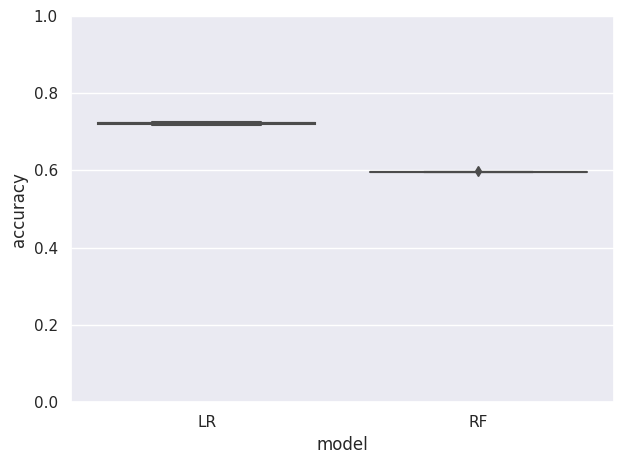

In [48]:
# Accuracy
box_plot(evaluation_metrics_df, model_col, accuracy_col)

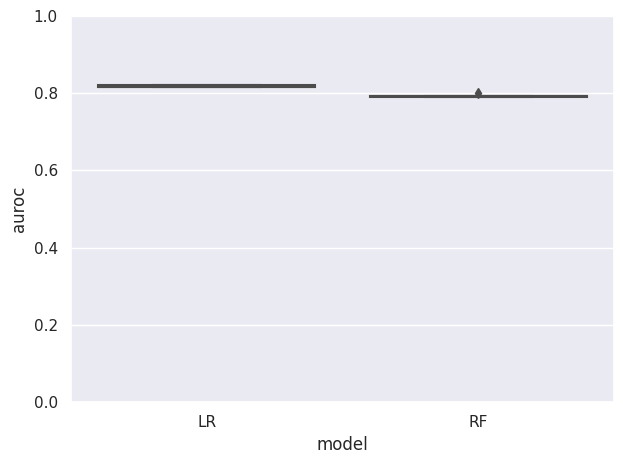

In [49]:
# AUROC
box_plot(evaluation_metrics_df, model_col, auroc_col)

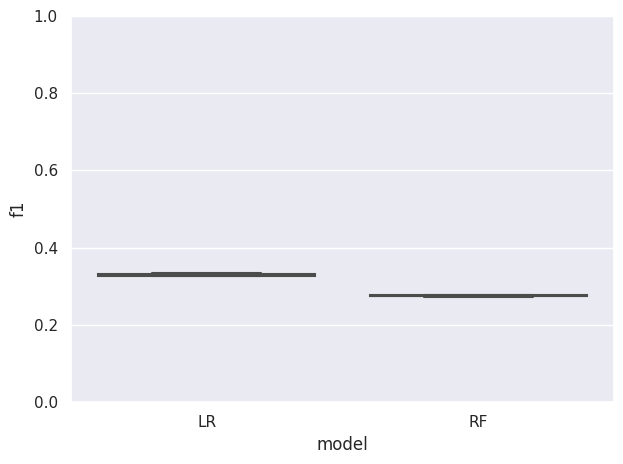

In [51]:
# F1
box_plot(evaluation_metrics_df, model_col, f1_col)

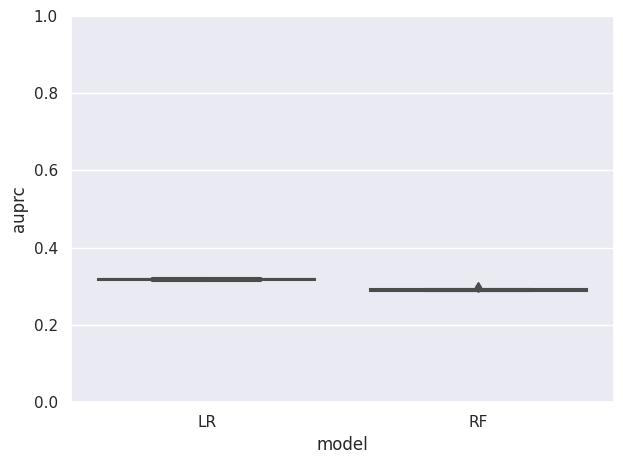

In [52]:
# AUPRC
box_plot(evaluation_metrics_df, model_col, auprc_col)